### Импорт необходимых библиотек и загрузка датасета

In [ ]:
!pip uninstall albumentations
!pip install albumentations


Found existing installation: albumentations 1.4.20
Uninstalling albumentations-1.4.20:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/albumentations-1.4.20.dist-info/*
    /usr/local/lib/python3.10/dist-packages/albumentations/*
Proceed (Y/n)? Y
  Successfully uninstalled albumentations-1.4.20
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.1/605.1 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19


In [ ]:
!pip install opendatasets

In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import *
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

import opendatasets as op

In [ ]:
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zergonikgaming
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:06<00:00, 117MB/s]


In [ ]:
image_dir = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
label_dir = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks'


### Визуализация данных

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))            # отображаем картинку
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()                                                            # выводим график целиком

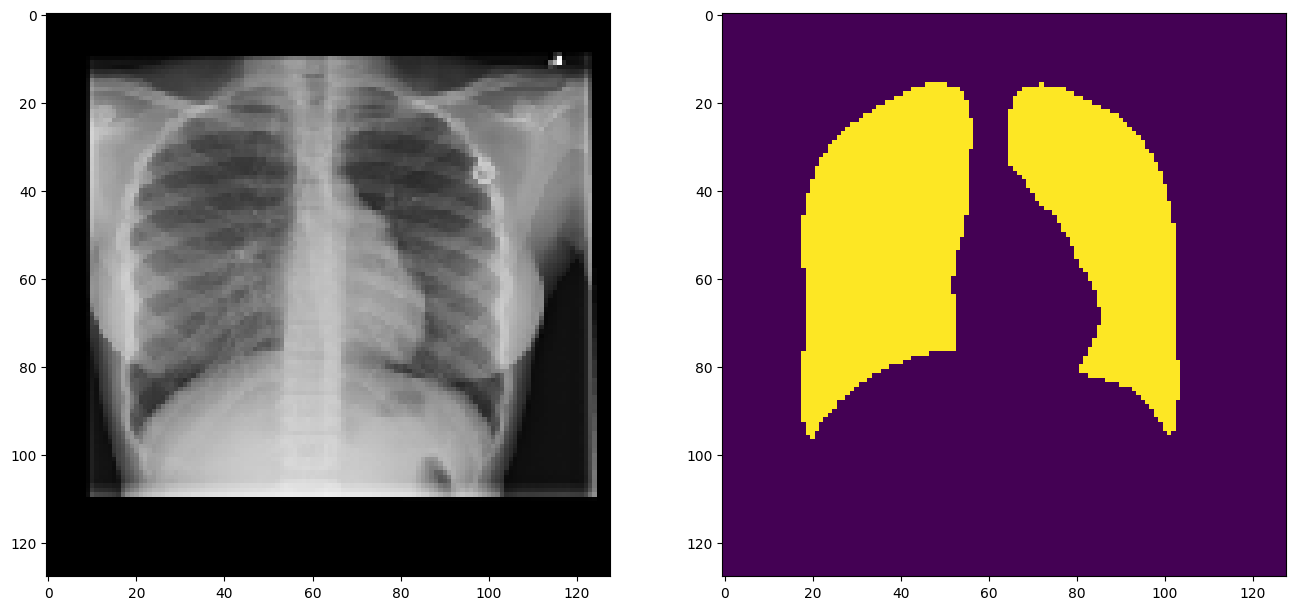

In [ ]:
original_image = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png"       # путь до ориганального изображения
label_image_semantic = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-1.png"  # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(128, 128), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(128, 128), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

### Создание датасета для обучения

In [ ]:
input_img_path = sorted(
    [
        os.path.join(image_dir, fname)
        for fname in os.listdir(image_dir)
        if fname.endswith(".png")
    ]
)

target_img_path = sorted(
    [
        os.path.join(label_dir, fname)
        for fname in os.listdir(label_dir)
        if fname.endswith(".png")
    ]
)

# Определим batch_size равный 16.
# Как опеределили? Запустили обучение на 8, 16, 32 и посмотрели на точность обучения, скорость обучения и потребляемые ресурсы
# Наиболее оптимальным оказался вариант с размером пакета в 16 образцов
batch_size = 32
img_size = (128, 128)
num_classes = 2           # число классов берем 2(объект и фон)

#### Использование генератора выборки **keras.utils.Sequence**

In [ ]:
# Генератор для перебора данных (в виде массивов Numpy)

class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = num_classes, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, num_classes), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 канал для маски

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([ # определяем функцию аугментации
                                A.Flip(p=0.5), # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5), # Случайный поворот на 90 градусов
                                A.RandomSnow(p=0.5)
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255 # нормализуем изображение
            mask = (mask > 127).astype(np.uint8)
            y[_] = to_categorical(mask, num_classes=num_classes) # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y


In [ ]:
import random

seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

In [ ]:
directory_path_images =  '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'

images_list = [f for f in os.listdir(directory_path_images) if os.path.isfile(os.path.join(directory_path_images, f))]

# Подсчитываем количество файлов
num_files = len(images_list)

print(f"Количество картинок в директории: {num_files}")

Количество картинок в директории: 10192


In [ ]:
directory_path_label =  '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks'

label_images_list = [f for f in os.listdir(directory_path_label) if os.path.isfile(os.path.join(directory_path_label, f))]

# Подсчитываем количество файлов
num_files = len(label_images_list)

print(f"Количество меток в директории: {num_files}")

Количество меток в директории: 10192


Расщепим наш датасет на обучающую и проверочную выборки. Так как у нас всего 10192 изображений, то на проверочную выборку возьмем всего 1200 изображений.

In [ ]:
val_samples = 1200

# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

Создадим экземпляры класса для нашего генератора выборки, инициализируем его расщепленными выше выборками.

In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, num_classes)

val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, num_classes, validation = True)

### Архитектура сети

In [ ]:
def U_Net_plus_plus(img_size, num_classes):

    nb_filter = [32,64,128,256,512]

    # Входной слой - желтый блок
    inputs = Input(img_size)

    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.5) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = Dropout(0.5) (c1)
    p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.5) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = Dropout(0.5) (c2)
    p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
    conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
    c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
    c3 = Dropout(0.5) (c3)
    c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = Dropout(0.5) (c3)

    conv3_1 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    conv3_1 = Dropout(0.5) (conv3_1)
    conv3_1 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
    conv3_1 = Dropout(0.5) (conv3_1)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
    conv2_2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
    conv2_2 = Dropout(0.5) (conv2_2)
    conv2_2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
    conv2_2 = Dropout(0.5) (conv2_2)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
    conv1_3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
    conv1_3 = Dropout(0.5) (conv1_3)
    conv1_3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
    conv1_3 = Dropout(0.5) (conv1_3)

    conv4_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
    conv4_1 = Dropout(0.5) (conv4_1)
    conv4_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
    conv4_1 = Dropout(0.5) (conv4_1)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
    conv3_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
    conv3_2 = Dropout(0.5) (conv3_2)
    conv3_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
    conv3_2 = Dropout(0.5) (conv3_2)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
    conv2_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
    conv2_3 = Dropout(0.5) (conv2_3)
    conv2_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
    conv2_3 = Dropout(0.5) (conv2_3)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
    conv1_4 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
    conv1_4 = Dropout(0.5) (conv1_4)
    conv1_4 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
    conv1_4 = Dropout(0.5) (conv1_4)

    conv5_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
    conv5_1 = Dropout(0.5) (conv5_1)
    conv5_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
    conv5_1 = Dropout(0.5) (conv5_1)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
    conv4_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
    conv4_2 = Dropout(0.5) (conv4_2)
    conv4_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
    conv4_2 = Dropout(0.5) (conv4_2)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
    conv3_3 = Dropout(0.5) (conv3_3)
    conv3_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
    conv3_3 = Dropout(0.5) (conv3_3)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
    conv2_4 = Dropout(0.5) (conv2_4)
    conv2_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
    conv2_4 = Dropout(0.5) (conv2_4)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
    conv1_5 = Dropout(0.5) (conv1_5)
    conv1_5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
    conv1_5 = Dropout(0.5) (conv1_5)

    nestnet_output_4 = Conv2D(num_classes, kernel_size = (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

    model = Model([inputs], [nestnet_output_4])

    return model

In [ ]:
input_shape = (img_size[0], img_size[1], 3) # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net_plus_plus(input_shape, num_classes) # инициализируем модель

В качестве функции ошибки мы используем `categorical_crossentropy`, так как выходные данные преобразованы с помощью `to_categorical`.

In [ ]:
model.compile(
    optimizer='adam' ,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)
]

In [ ]:
model.summary() # отчет о структуре модели

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool3 (MaxPooling2D)      │ (None, 16, 16, 64)     │              0 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ pool3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout) 

 Total params: 2,749,746 (10.49 MB)

 Trainable params: 2,749,746 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

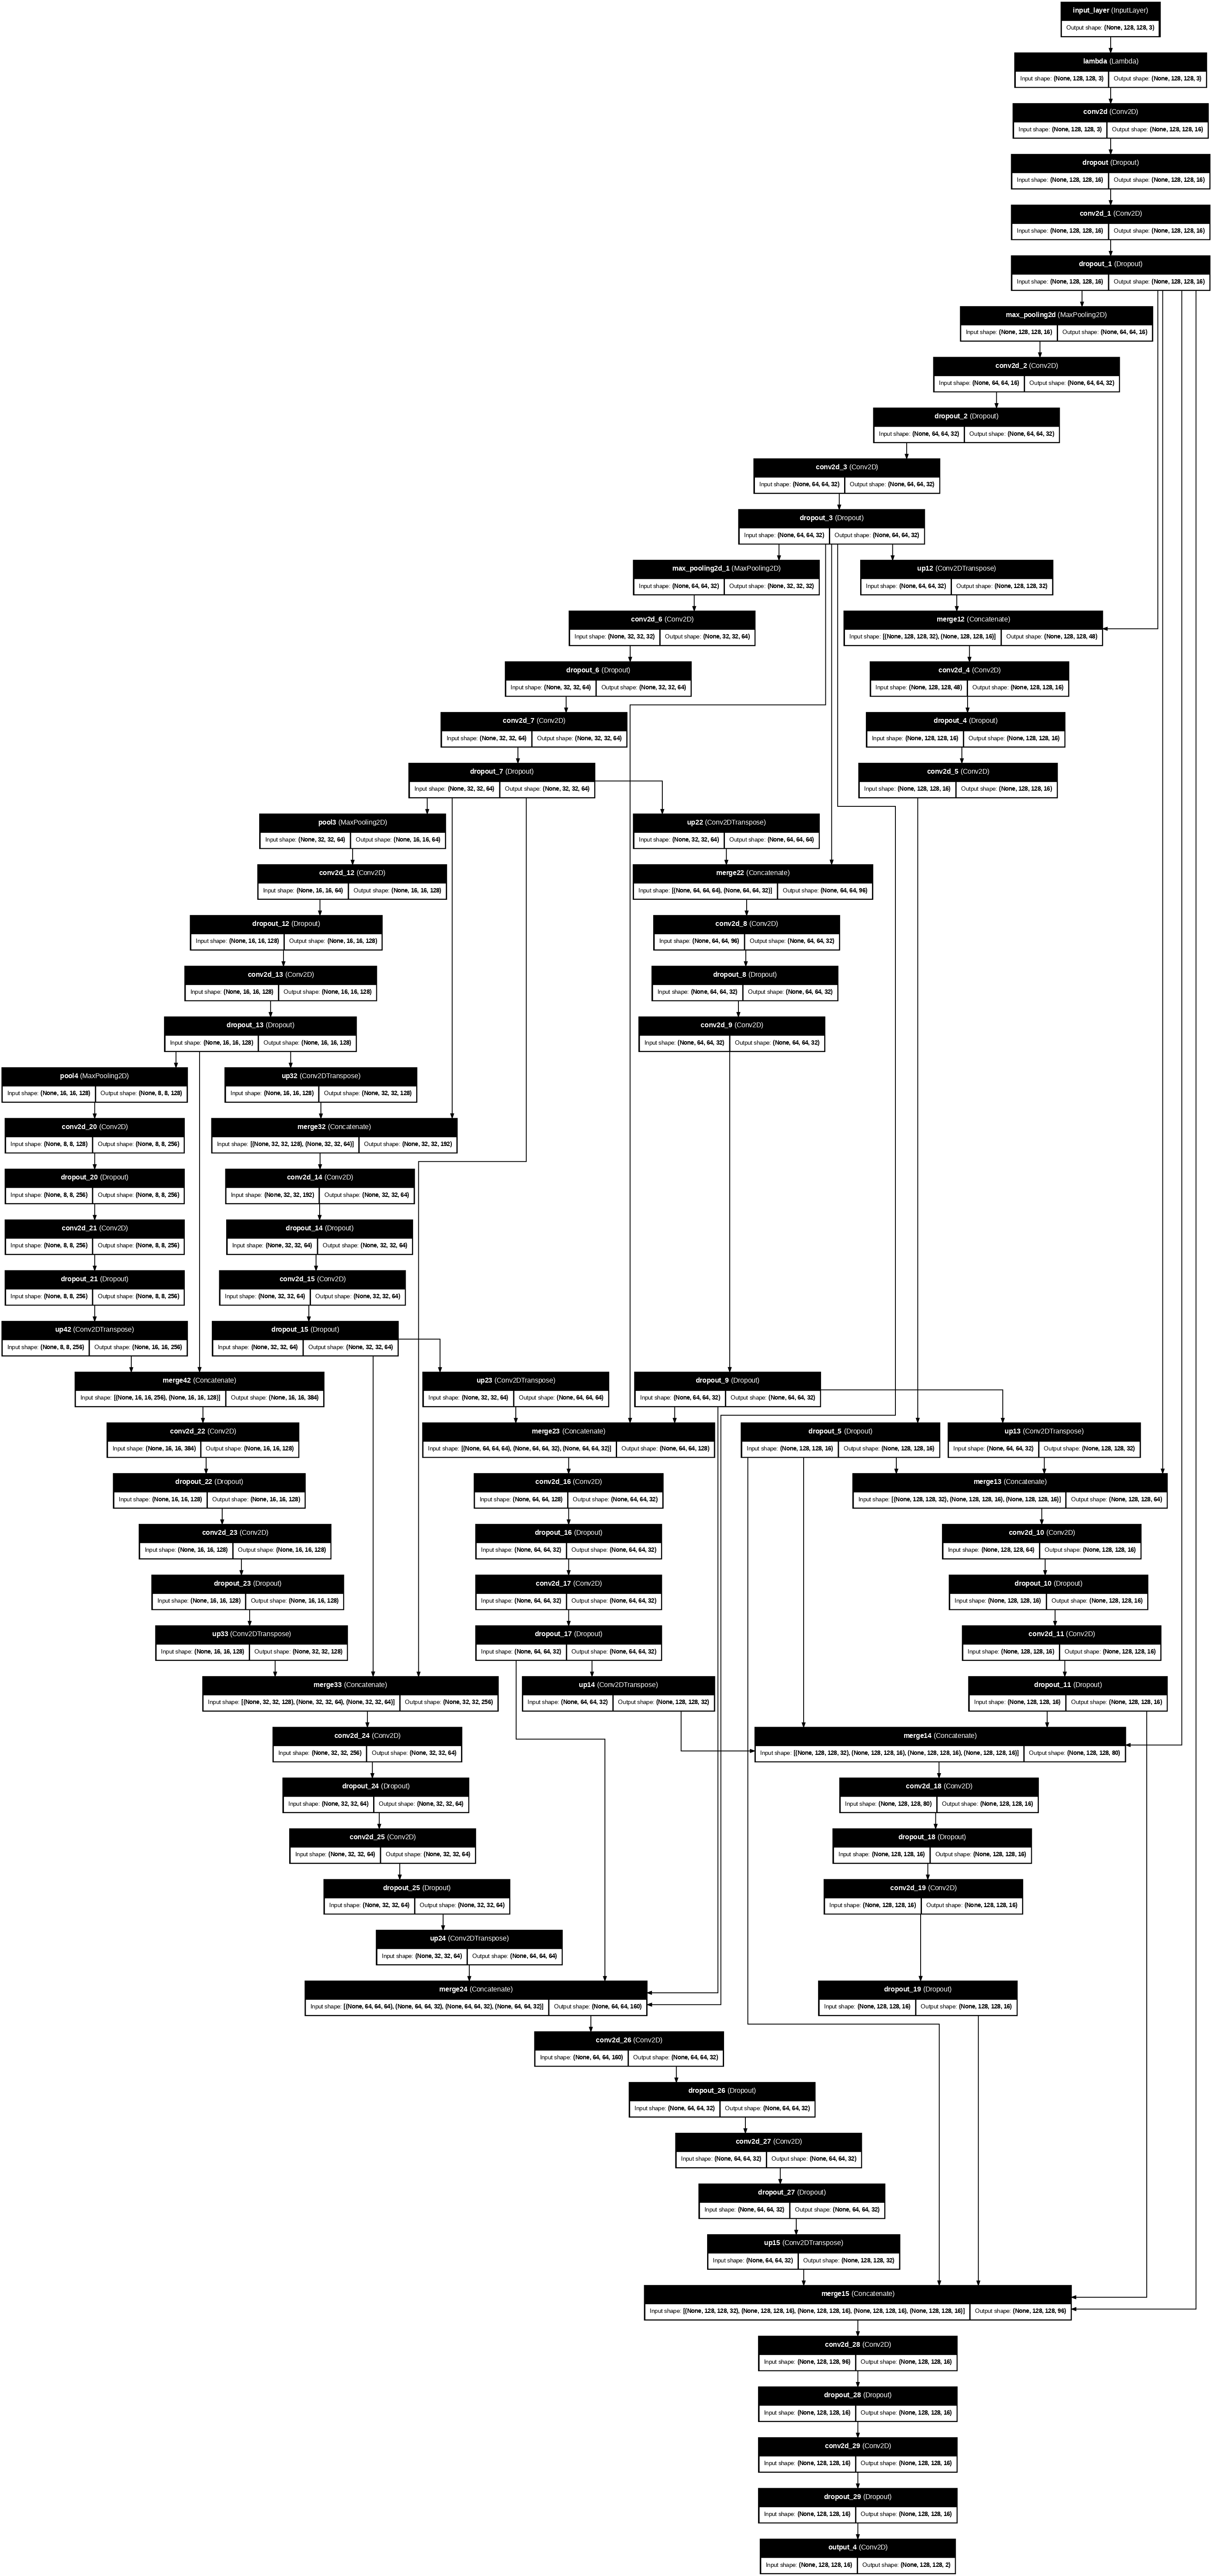

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

### Обучение модели

In [ ]:
epochs = 20
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks
                   )

<ipython-input-9-2b0b325b10c3>:43: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5), # Отражение изображения по горизонтали и вертикали


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


281/281 ━━━━━━━━━━━━━━━━━━━━ 127s 255ms/step - accuracy: 0.7699 - loss: 0.4978 - val_accuracy: 0.8527 - val_loss: 0.3187
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 73s 254ms/step - accuracy: 0.9213 - loss: 0.1977 - val_accuracy: 0.8621 - val_loss: 0.3650
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 258ms/step - accuracy: 0.9488 - loss: 0.1295 - val_accuracy: 0.9654 - val_loss: 0.0884
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - accuracy: 0.9599 - loss: 0.1026 - val_accuracy: 0.9687 - val_loss: 0.0889
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 73s 254ms/step - accuracy: 0.9678 - loss: 0.0833 - val_accuracy: 0.9778 - val_loss: 0.0529
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 73s 255ms/step - accuracy: 0.9722 - loss: 0.0722 - val_accuracy: 0.9807 - val_loss: 0.0470
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 254ms/step - accuracy: 0.9746 - loss: 0.0663 - val_accuracy: 0.9783 - val_loss: 0.0538
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 73s 258ms/step - accuracy: 0.9744 - loss: 0.0681 - va

### Анализ результатов обучения

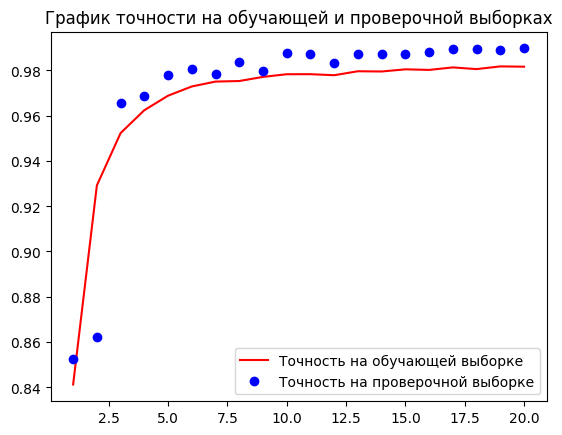

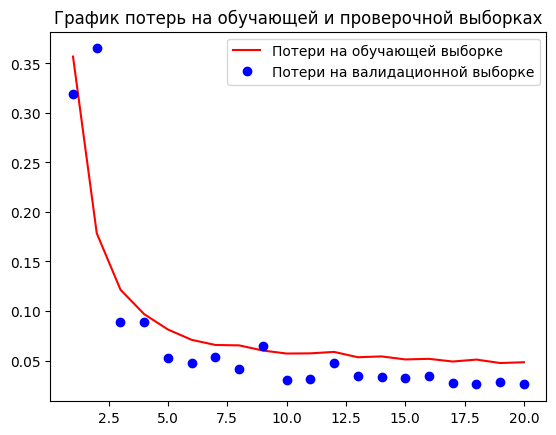

In [ ]:
acc = history.history['accuracy']                              # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                      # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

### Визуальная оценка результата сегментации на тестовой выборке

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем картинку
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 80%
    plt.axis('off')
  plt.show()

Определим функцию создания маски и отобразим 12 образцов изображений, а также соответствующих им оригинальные и предсказанные маски.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


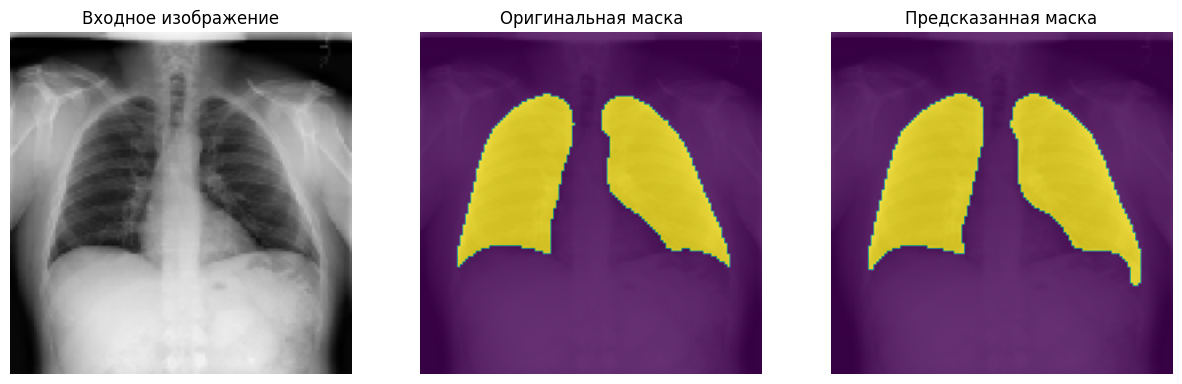

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


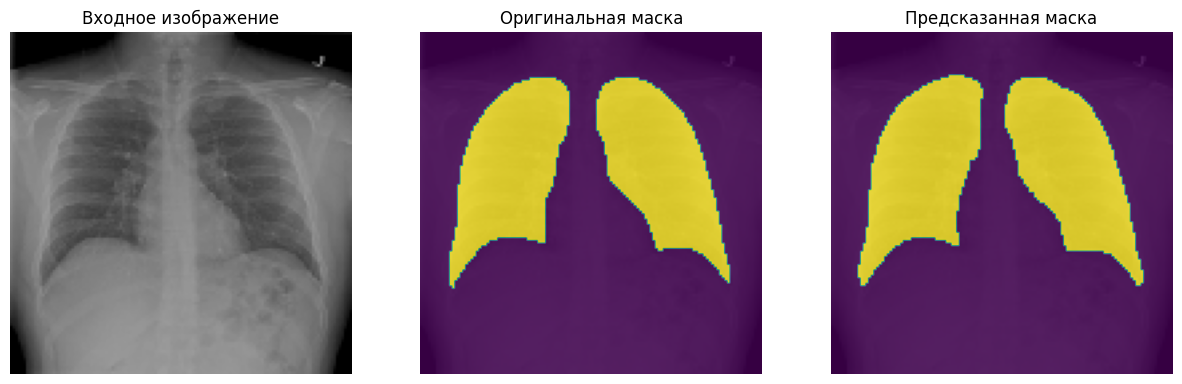

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


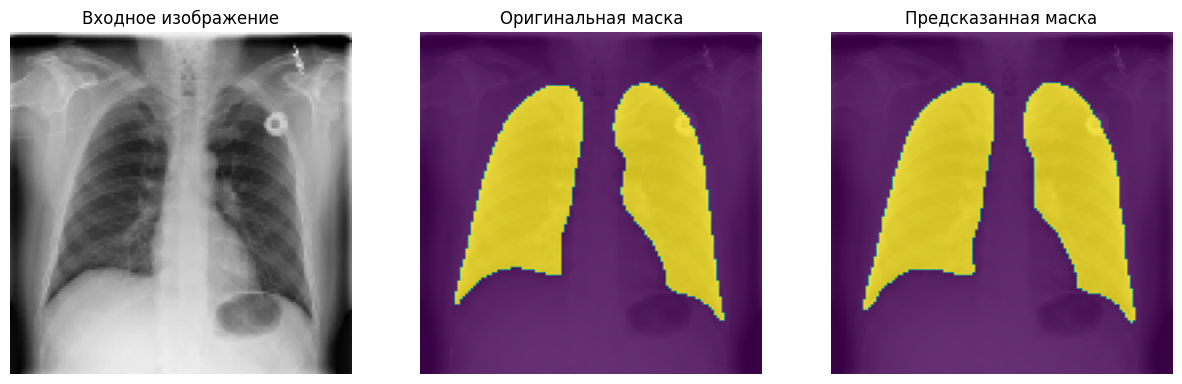

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


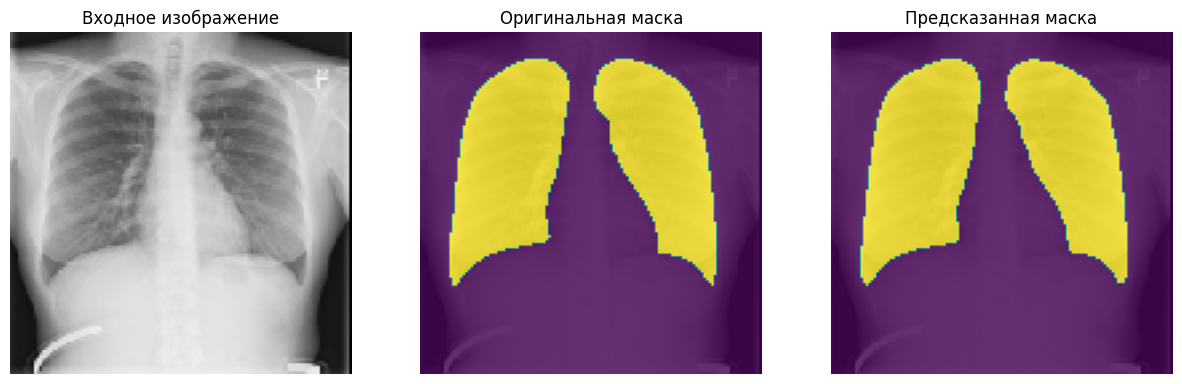

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


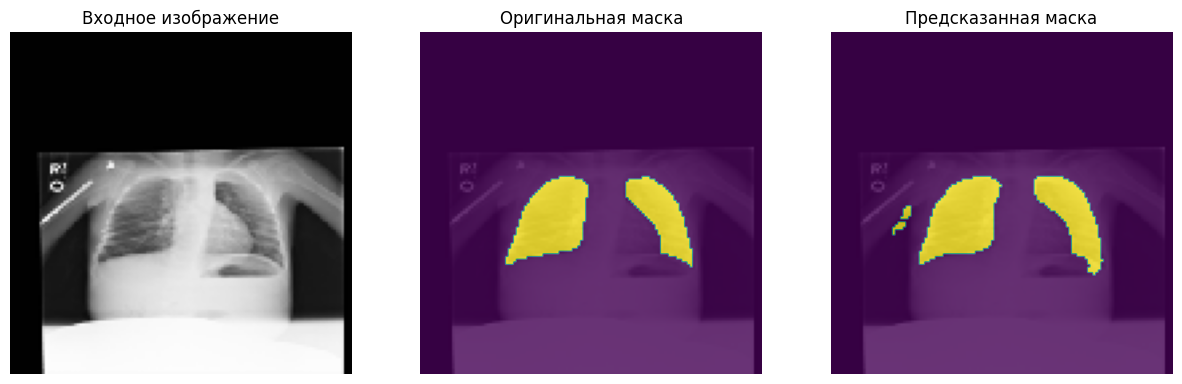

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


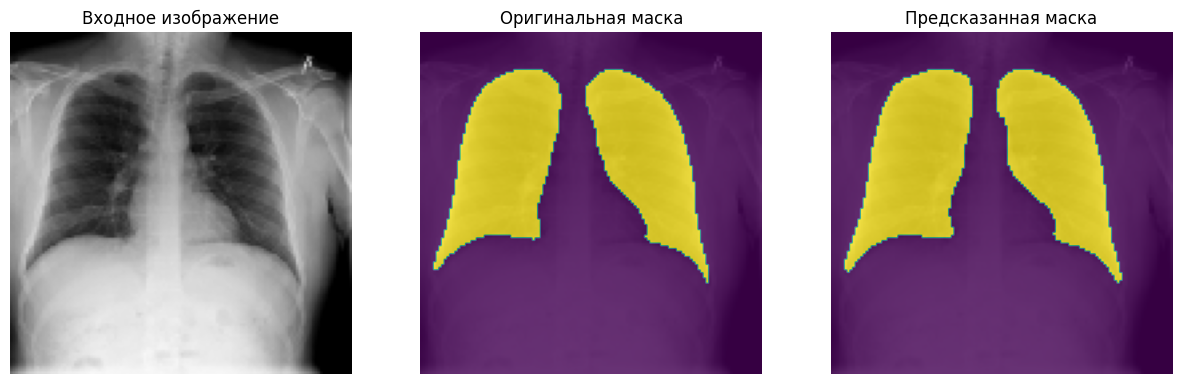

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


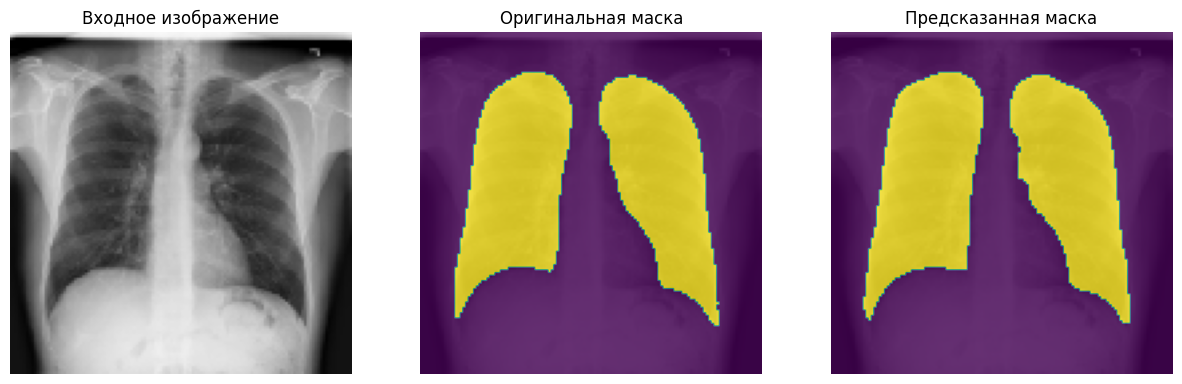

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


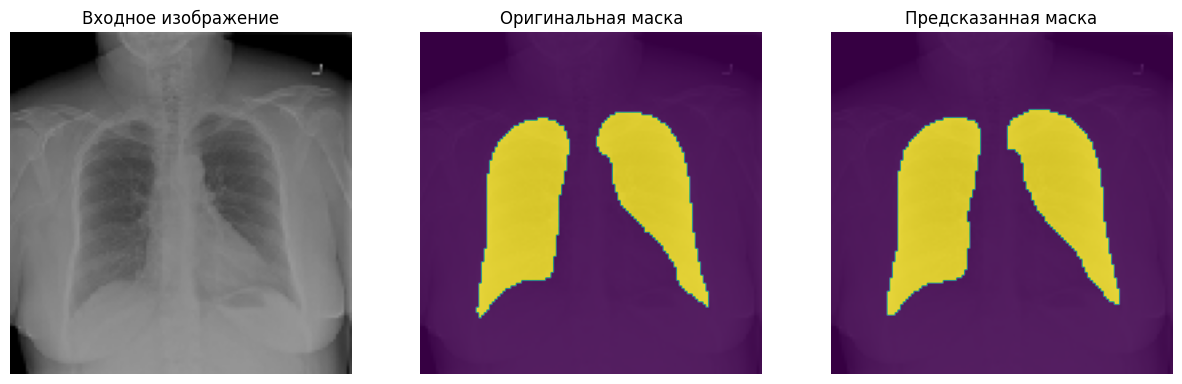

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


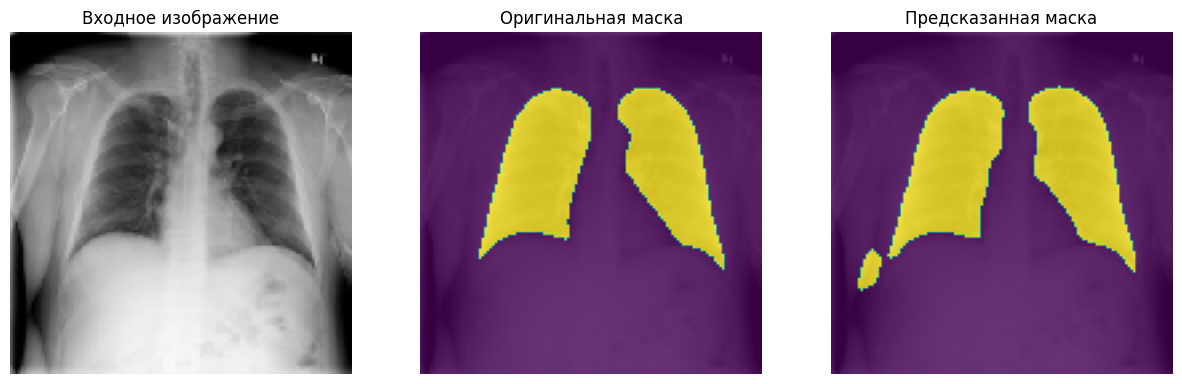

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


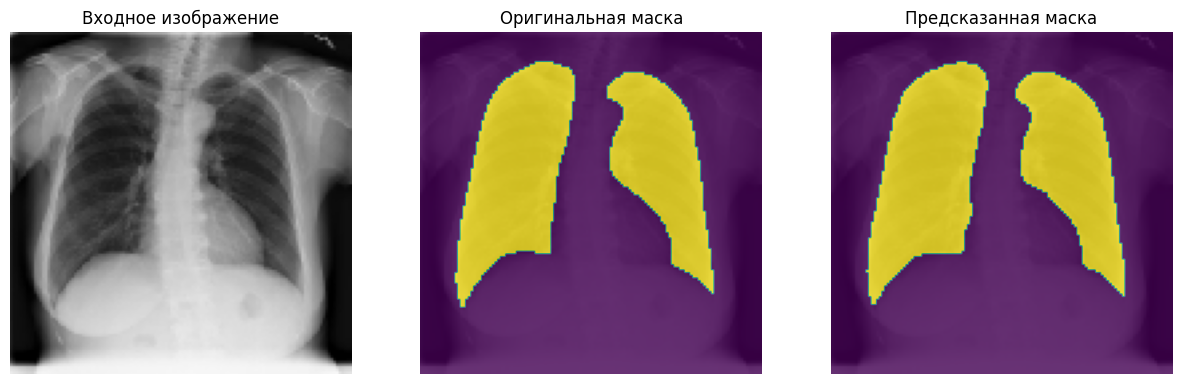

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


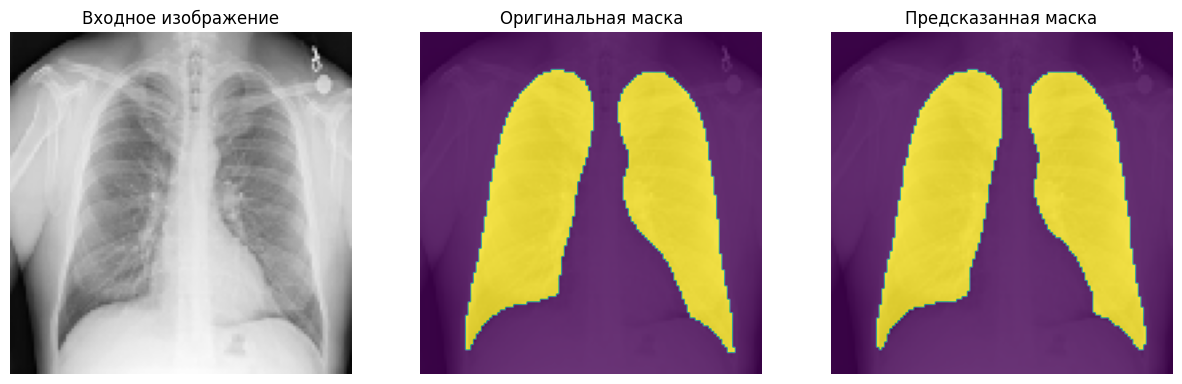

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


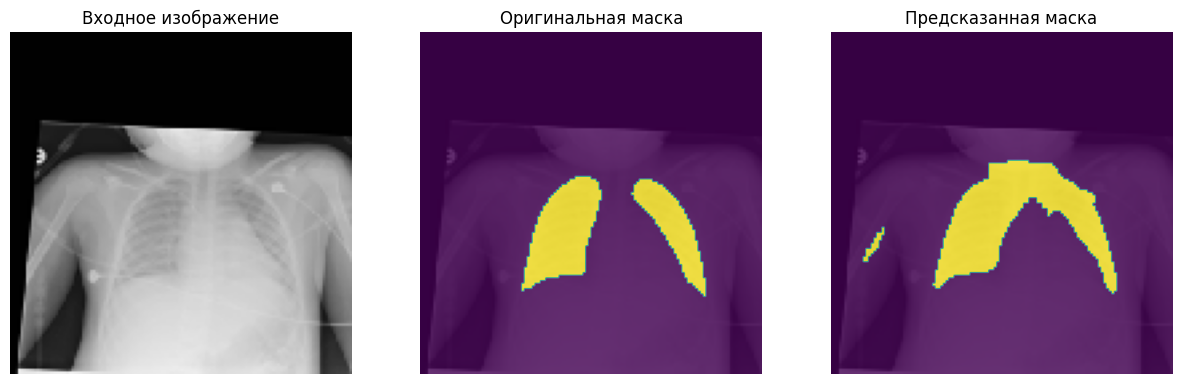

In [ ]:
for index in range(12):                  # выбираем 12 картинок и выводим их в цикле
    img = np.array(load_img(val_input_img_path[index], target_size=(128, 128), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(128, 128), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 128, 128, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную